# Detection of the ball

The idea here is:
- I seach for the ball in the first rectangular of the image
- When I detect a ball I restrict the detection for the successive ball whitin a rectangular not so much larger then the ball
- I use the detected rectangle for the successive detection and I resize it with the new ball detected
- And so on

IMPORTANT: understand how to set the first rectangular in which detect the ball

In [27]:
# Import libraries
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

In [28]:
# --- Configuration ---
VIDEO_NUM = "3"
CONSISTENCY_THRESHOLD = 5
POSITION_TOLERANCE = 35
RADIUS_TOLERANCE = 10
ROI_MARGIN = 50
MAX_LOST_FRAMES = 2                 # TODO: this can be used dynamically

In [29]:
# --- Paths ---
PROJECT_ROOT = Path().resolve().parent.parent
VIDEO_PATH = PROJECT_ROOT / "data" / f"recording_{VIDEO_NUM}" / f"Recording_{VIDEO_NUM}.mp4"
CSV_PATH = PROJECT_ROOT / "data" / "auxiliary_data" / "lane_points" / f"Lane_points_{VIDEO_NUM}.csv"

# --- Load Data ---
df = pd.read_csv(CSV_PATH)
cap = cv2.VideoCapture(str(VIDEO_PATH))
if not cap.isOpened():
    raise IOError("Error opening video file!")

fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video opened: FPS={fps}, Total Frames={total_frames}")

Video opened: FPS=59.94005994005994, Total Frames=227


In [30]:
# --- State Variables ---
last_circle = None
consistency_counter = 0
lost_counter = 0
use_roi = False
search_roi = None
frame_idx = 0
first_time = True
scale_factor = 0.6
r_approx = None

In [31]:
def get_points_for_frame(df: pd.DataFrame, frame_number: int) -> np.ndarray:
    row = df[df['Frame'] == frame_number]
    if row.empty:
        raise ValueError(f"No points found for frame {frame_number}")
    return np.array([
        [row['bottom_left_x'].values[0], row['bottom_left_y'].values[0]],
        [row['bottom_right_x'].values[0], row['bottom_right_y'].values[0]],
        [row['up_right_x'].values[0], row['up_right_y'].values[0]],
        [row['up_left_x'].values[0], row['up_left_y'].values[0]]
    ], dtype=np.int32)

In [32]:
def compute_modified_polygon(points: np.ndarray) -> np.ndarray:
    top_indices = np.argsort(points[:, 1])[:2]
    top_points = points[top_indices]
    left_top, right_top = sorted(top_points, key=lambda pt: pt[0])

    left_top_mod = [left_top[0] - 50, left_top[1] - 70]
    right_top_mod = [right_top[0] + 50, right_top[1] - 70]

    return np.array([
        left_top_mod if np.array_equal(pt, left_top) else
        right_top_mod if np.array_equal(pt, right_top) else pt
        for pt in points
    ], dtype=np.int32)

In [33]:
def compute_upper_polygon(points: np.ndarray) -> np.ndarray:
    top_indices = np.argsort(points[:, 1])[:2]
    top_points = points[top_indices]
    left_top, right_top = sorted(top_points, key=lambda pt: pt[0])
    
    left_top_mod = [left_top[0] - 500, left_top[1] + 150]                                   # TODO: calculate it in another way (proportions between the lines?)
    right_top_mod = [right_top[0] + 150, right_top[1] + 150]                                # TODO: calculate it in another way (proportions between the lines?)

    return np.array([
        left_top_mod if np.array_equal(pt, left_top) else
        right_top_mod if np.array_equal(pt, right_top) else pt
        for pt in points
    ], dtype=np.int32)

In [34]:
def remove_background(frame_number: int, df: pd.DataFrame, image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    points = get_points_for_frame(df, frame_number)
    polygon = compute_modified_polygon(points)
    mask = cv2.fillPoly(np.zeros(image.shape[:2], dtype=np.uint8), [polygon], 255)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result, polygon

In [35]:
def preprocess_roi(image: np.ndarray) -> np.ndarray:
    return cv2.medianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 5)

In [36]:
def compute_approx_radius(df: pd.DataFrame) -> int:
    points = get_points_for_frame(df, 0)
    radius = int(np.linalg.norm(points[0] - points[1]) / 10)
    return radius

In [ ]:
def detect_circle(preprocessed_img: np.ndarray, frame_number: int, r_approx: int) -> np.ndarray | None:

    min_radius = int(r_approx * 0.65)
    max_radius = int(r_approx)
    print(f"Frame {frame_number}: min radius={min_radius}, max radius={max_radius}")

    return cv2.HoughCircles(
        preprocessed_img,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=50,
        param1=100,
        param2=40,
        minRadius=min_radius,
        maxRadius=max_radius
    )

def detect_circle_after_roi(preprocessed_img: np.ndarray, frame_number: int, r_approx: int) -> np.ndarray | None:

    min_radius = max(0, int(r_approx*0.7))
    max_radius = int(r_approx*1.1)
    print(f"Frame {frame_number}: min radius={min_radius}, max radius={max_radius}")

    return cv2.HoughCircles(
        preprocessed_img,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=50,
        param1=100,
        param2=40,
        minRadius=min_radius,
        maxRadius=max_radius
    )

def detect_circle_roi(preprocessed_img: np.ndarray, frame_number: int, r_approx: int) -> np.ndarray | None:

    min_radius = max(0, int(r_approx*0.9))
    max_radius = int(r_approx*1.08)
    print(f"Frame {frame_number}: min radius={min_radius}, max radius={max_radius}")

    return cv2.HoughCircles(
        preprocessed_img,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=500,
        param1=200,
        param2=10,
        minRadius=min_radius,
        maxRadius=max_radius
    )

In [38]:
def update_roi(x: int, y: int, r: int, frame_shape, base_margin: int, scale_factor: float) -> tuple[int, int, int, int]:
    height, width = frame_shape[:2]
    dynamic_margin = max(int(r * scale_factor), 10)  # Ensure at least some margin

    x_min = max(0, x - r - dynamic_margin)     # -10 to avoid cutting the circle
    y_min = max(0, y - r - dynamic_margin)     # -10 to avoid cutting the circle
    x_max = min(width, x + r + dynamic_margin) # +10 to avoid cutting the circle
    y_max = min(height, y + r + 3)
    print(f"ROI: width={x_max - x_min}, height={y_max - y_min}")

    return (x_min, y_min, x_max, y_max)

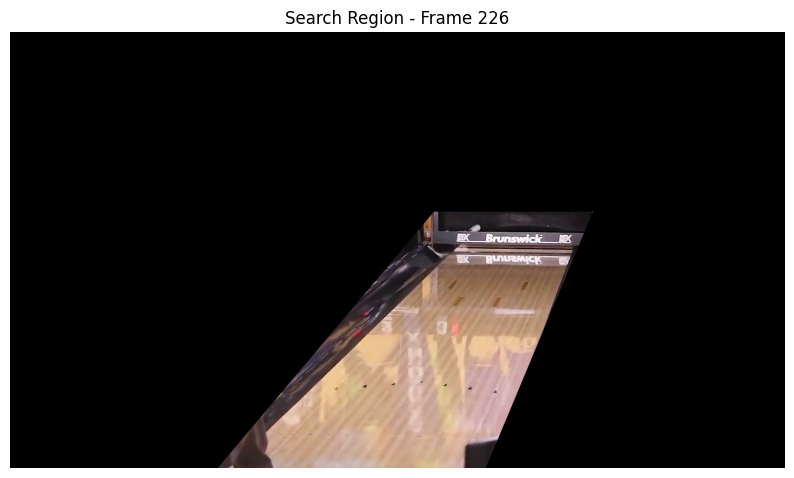

End of video or cannot read frame.
Processing complete.


In [39]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("End of video or cannot read frame.")
        break

    try:
        # Remove background
        masked_frame, _ = remove_background(frame_idx, df, frame)

        # Choice of the "search region"
        if consistency_counter < CONSISTENCY_THRESHOLD and first_time:
            # Search in the upper polygon
            upper_polygon = compute_upper_polygon(get_points_for_frame(df, frame_idx))
            upper_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
            cv2.fillPoly(upper_mask, [upper_polygon], 255)
            search_region = cv2.bitwise_and(masked_frame, masked_frame, mask=upper_mask)
            roi_offset = (0, 0)
            preprocessed = preprocess_roi(search_region)
            r_approx = compute_approx_radius(df)
            circles = detect_circle(preprocessed, frame_idx, r_approx)
        elif use_roi and search_roi:
            # Detection in the ROI
            x_min, y_min, x_max, y_max = search_roi
            search_region = masked_frame[y_min:y_max, x_min:x_max]
            roi_offset = (x_min, y_min)
            preprocessed = preprocess_roi(search_region)
            circles = detect_circle_roi(preprocessed, frame_idx, r_approx)
        else:
            # Fallback in the full masked frame
            search_region = masked_frame
            roi_offset = (0, 0)
            preprocessed = preprocess_roi(search_region)
            circles = detect_circle_after_roi(preprocessed, frame_idx, r_approx)

        # Detect cicles in the search region
        #preprocessed = preprocess_roi(search_region)
        #circles = detect_circle(preprocessed, frame_idx, r_approx)
        valid_circle = None

        if circles is not None:
            x, y, r = np.round(circles[0, 0]).astype("int")
            x_global, y_global, r_global = x + roi_offset[0], y + roi_offset[1], r
            valid_circle = (x + roi_offset[0], y + roi_offset[1], r_global)

        if valid_circle:
            dx, dy, dr = np.abs(np.subtract(valid_circle, last_circle)) if last_circle else (0, 0, 0)
            if last_circle and dx < POSITION_TOLERANCE and dy < POSITION_TOLERANCE and dr < RADIUS_TOLERANCE:
                consistency_counter += 1
            else:
                consistency_counter = 1

            last_circle = valid_circle
            lost_counter = 0

            # Draw circle
            x_roi, y_roi = valid_circle[0] - roi_offset[0], valid_circle[1] - roi_offset[1]
            cv2.circle(search_region, (x_roi, y_roi), valid_circle[2], (0, 255, 0), 2)
            cv2.circle(search_region, (x_roi, y_roi), 2, (0, 0, 255), 3)

            if consistency_counter >= CONSISTENCY_THRESHOLD:
                search_roi = update_roi(x_global, y_global, r_global, frame.shape, ROI_MARGIN, scale_factor)
                r_approx = r_global
                first_time = False
                use_roi = True
        else:
            lost_counter += 1
            if lost_counter >= MAX_LOST_FRAMES:
                use_roi = False
                consistency_counter = 0
                last_circle = None
                search_roi = None
                # r_approx = None

        # Display result
        display_frame = cv2.cvtColor(search_region, cv2.COLOR_BGR2RGB) #preprocessed
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.imshow(display_frame)
        plt.title(f"Search Region - Frame {frame_idx}")
        plt.axis("off")
        display(plt.gcf())
        plt.close()
        time.sleep(1 / fps)

    except ValueError as e:
        print(f"Skipping frame {frame_idx}: {e}")

    frame_idx += 1

cap.release()
print("Processing complete.")

IMPROVEMENT: Rescrict the radius of the ball when we are detecting it in full track (camera calibration)

[This code is implemented in Detection_3.py]